# Pulling Data From CoinMarketCap API

## Importing libraries

In [8]:
import pandas as pd
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import csv
import time
import smtplib
import seaborn as sns
import matplotlib.pyplot as plt

## Setting options & themes and creating the data frame & the csv file

In [10]:
pd.set_option('display.max.columns',None)
pd.set_option('display.max.rows',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_theme(style='darkgrid')
headers = ['id', 'name', 'symbol', 'slug', 'num_market_pairs', 'date_added',
       'tags', 'max_supply', 'circulating_supply', 'total_supply',
       'infinite_supply', 'platform', 'cmc_rank',
       'self_reported_circulating_supply', 'self_reported_market_cap',
       'tvl_ratio', 'last_updated', 'quote.USD.price', 'quote.USD.volume_24h',
       'quote.USD.volume_change_24h', 'quote.USD.percent_change_1h',
       'quote.USD.percent_change_24h', 'quote.USD.percent_change_7d',
       'quote.USD.percent_change_30d', 'quote.USD.percent_change_60d',
       'quote.USD.percent_change_90d', 'quote.USD.market_cap',
       'quote.USD.market_cap_dominance', 'quote.USD.fully_diluted_market_cap',
       'quote.USD.tvl', 'quote.USD.last_updated', 'platform.id',
       'platform.name', 'platform.symbol', 'platform.slug',
       'platform.token_address','TimeStamp']
df = pd.DataFrame(columns=headers)
with open(r'C:/Users/hp/Desktop/Python/CryptoAPIDataset.csv','w', newline='', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

## Creating a mailing function that sends Bitcoin price updates

In [12]:
def send_mail(Bitcoin_Price,TimeStamp):
    server = smtplib.SMTP_SSL('smtp.gmail.com',465)
    server.ehlo()
    server.login('raafat.2023@gmail.com','yekqpusipwoezkvn')
    subject = "Bitcoin Price Update"
    body = f"Bitcoin Price at ({TimeStamp}) = ${Bitcoin_Price:.2f}" 
    msg = f"Subject: {subject}\n\n{body}"
    server.sendmail('raafat.2023@gmail.com','raafat.2023@gmail.com',msg)

## Creating the function that imports data from the API
1. Import data as JSON and converting it to a data frame
2. Adding a timestamp column to the data frame
3. Appending the new data frame to the old one and to the csv file

In [14]:
def import_from_api():
    global df
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest' 
    parameters = {
      'start':'1',
      'limit':'15',
      'convert':'USD'
    }
    headers = {
      'Accepts': 'application/json',
      'X-CMC_PRO_API_KEY': '6bf81236-bcaf-4445-a2c8-677d8ac1d125',
    }
    session = Session()
    session.headers.update(headers)
    try:
      response = session.get(url, params=parameters)
      data = json.loads(response.text)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
      print(e)
      return
    df0 = pd.json_normalize(data['data'])
    df0['TimeStamp'] = pd.to_datetime('now')
    df = pd.concat([df,df0])
    df0.to_csv(r'C:/Users/hp/Desktop/Python/CryptoAPIDataset.csv', mode='a', header=False,index=False)

## Automating the two functions to run every 6 hours

In [ ]:
while (True):
    i = 0
    import_from_api()
    print('Import #',(i+1),' completed!')
    Bitcoin_Price = (df[df['name'] == 'Bitcoin'])['quote.USD.price'].iloc[0]
    TimeStamp = (df[df['name'] == 'Bitcoin'])['TimeStamp'].iloc[0]
    send_mail(Bitcoin_Price,TimeStamp)
    time.sleep(21600)

C:\Users\hp\AppData\Local\Temp\ipykernel_30788\2136749920.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df0])


Import # 1  completed!


## Visualizations

Text(0.5, 0.98, 'Change in Coin Price Over Time')

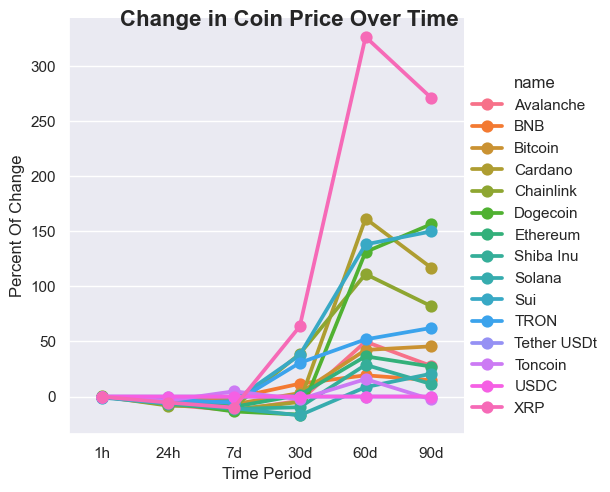

In [18]:
df1 = df.groupby('name')[['quote.USD.percent_change_1h','quote.USD.percent_change_24h','quote.USD.percent_change_7d','quote.USD.percent_change_30d','quote.USD.percent_change_60d','quote.USD.percent_change_90d']].mean()
df1 = df1.stack()
df1 = df1.to_frame(name = 'Percent Of Change')
df1 = df1.reset_index()
df1 = df1.rename(columns={'level_1':'Time Period'})
df1['Time Period'] = df1['Time Period'].str.replace('quote.USD.percent_change_','')
plot1 = sns.catplot(x='Time Period', y='Percent Of Change', hue='name', data=df1, kind='point')
plot1.fig.suptitle("Change in Coin Price Over Time", fontsize=16, fontweight="bold")

Text(0.5, 1.0, 'Bitcoin Price Over Time')

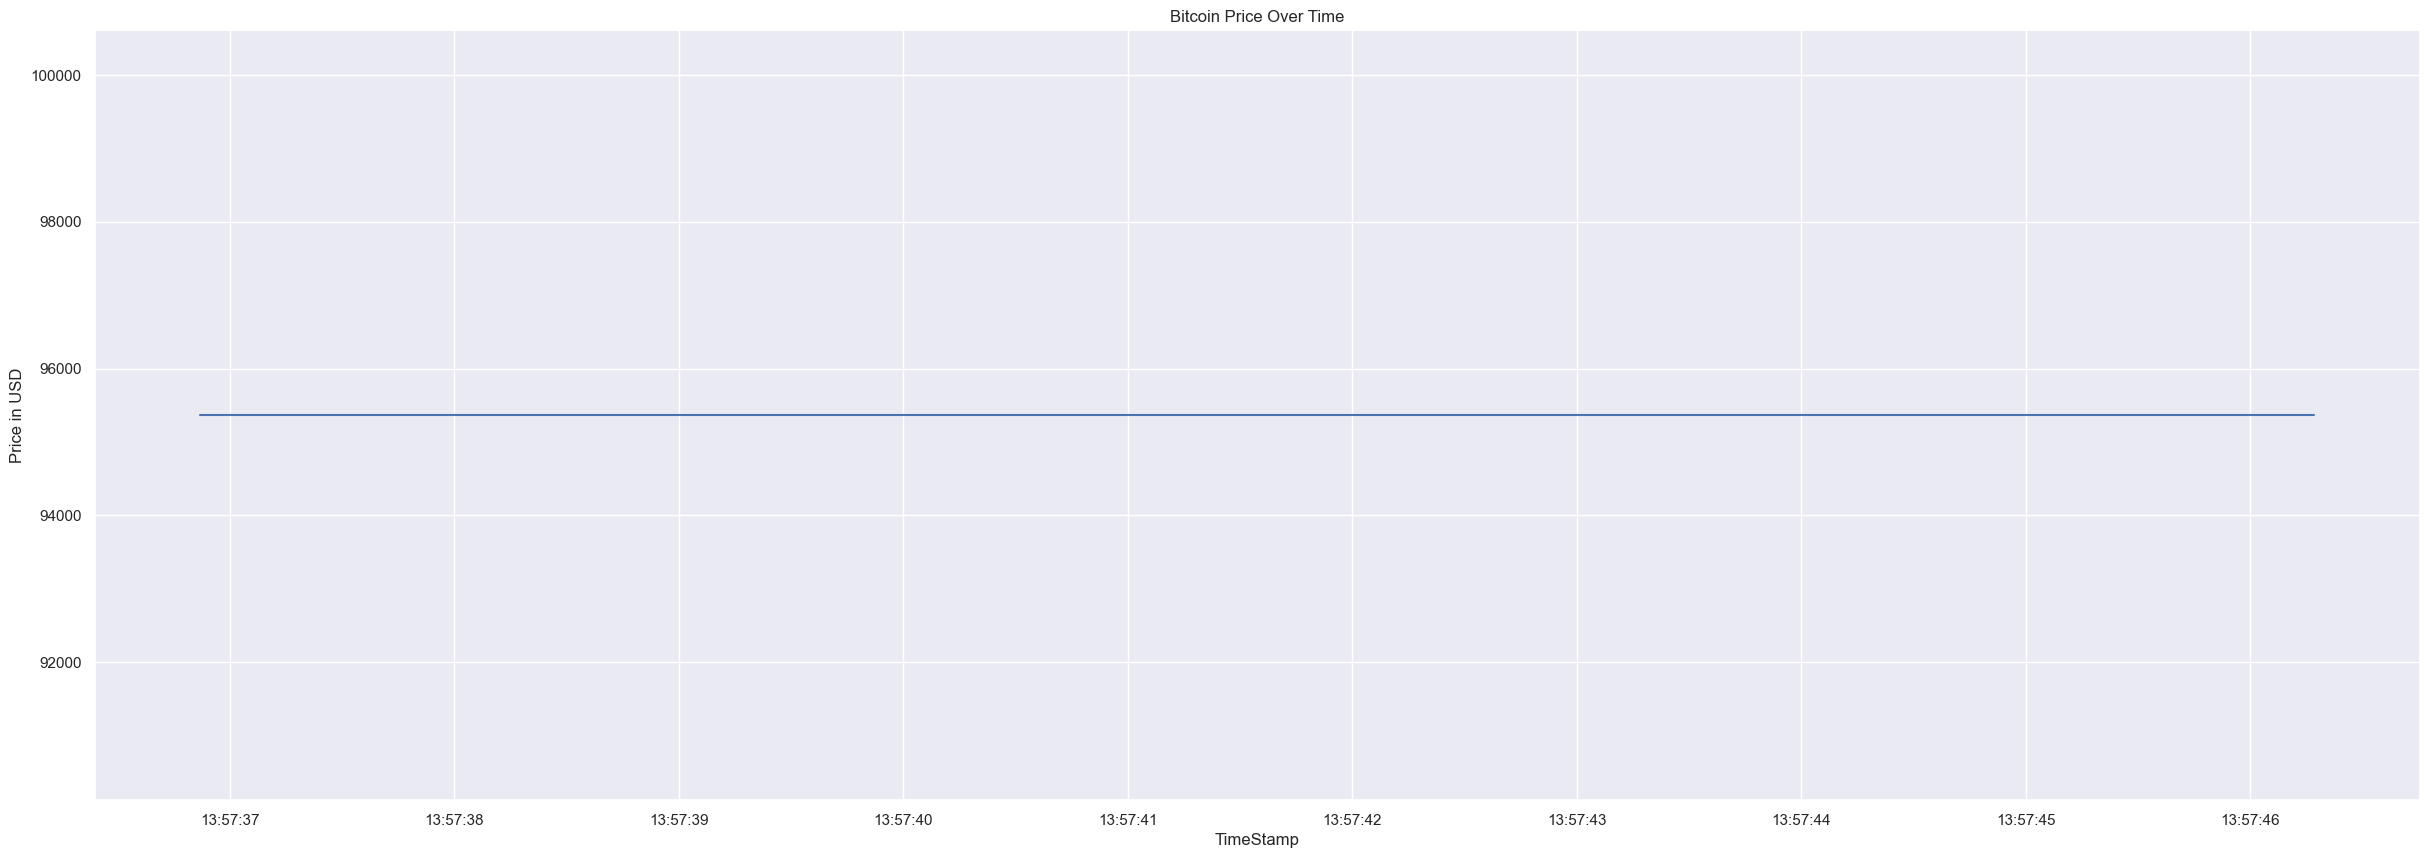

In [22]:
fig, ax = plt.subplots(figsize=(30, 10))
df2 = df[df['name'] == 'Bitcoin']
plot2 = sns.lineplot(x='TimeStamp', y='quote.USD.price', data = df2)
plot2.set_ylabel("Price in USD")
plot2.set_title("Bitcoin Price Over Time")

Text(0.5, 1.0, 'Current Circulating Supply')

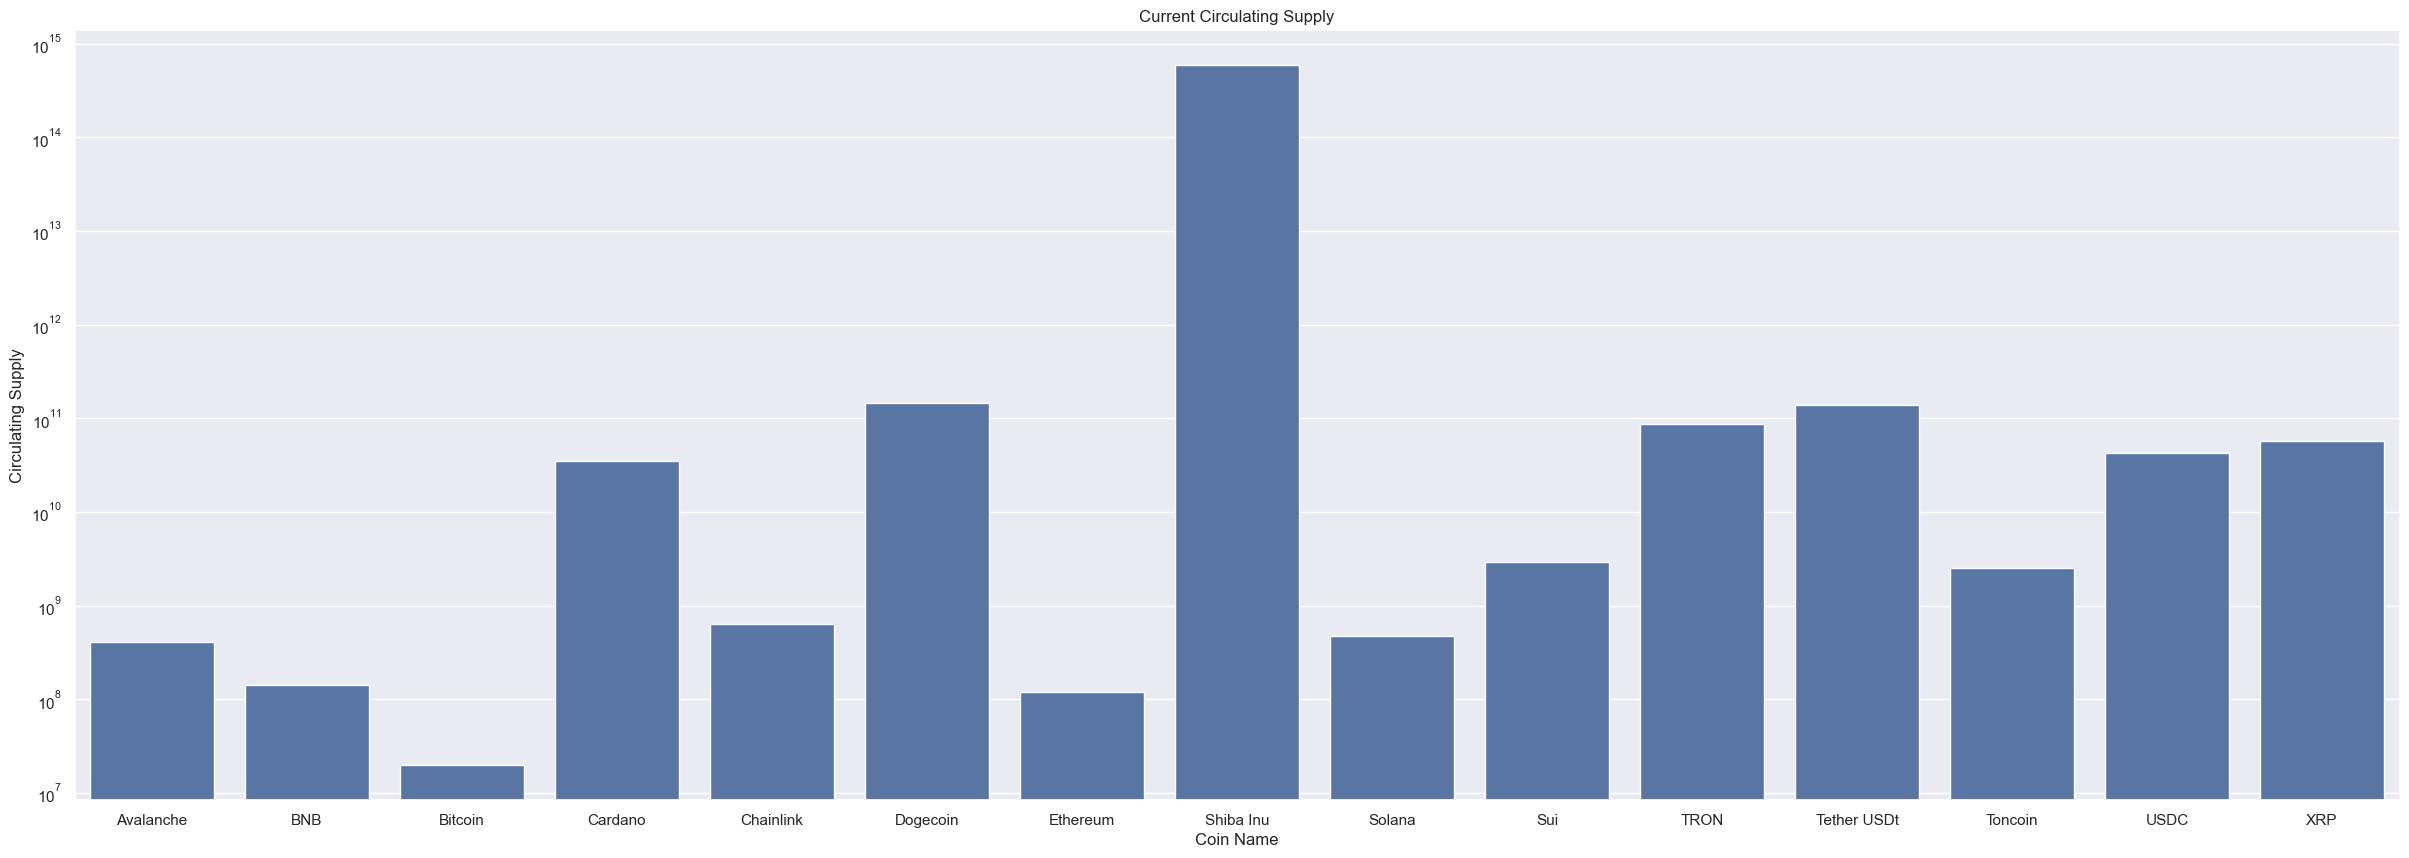

In [24]:
fig, ax = plt.subplots(figsize=(30, 10))
df4 = df.sort_values(by='TimeStamp').groupby('name').agg(circulating_supply=('circulating_supply', 'last'))
plot3 = sns.barplot(data = df4, x='name', y='circulating_supply')
plot3.set_yscale('log')
plot3.set_ylabel('Circulating Supply')
plot3.set_xlabel('Coin Name')
plot3.set_title('Current Circulating Supply')

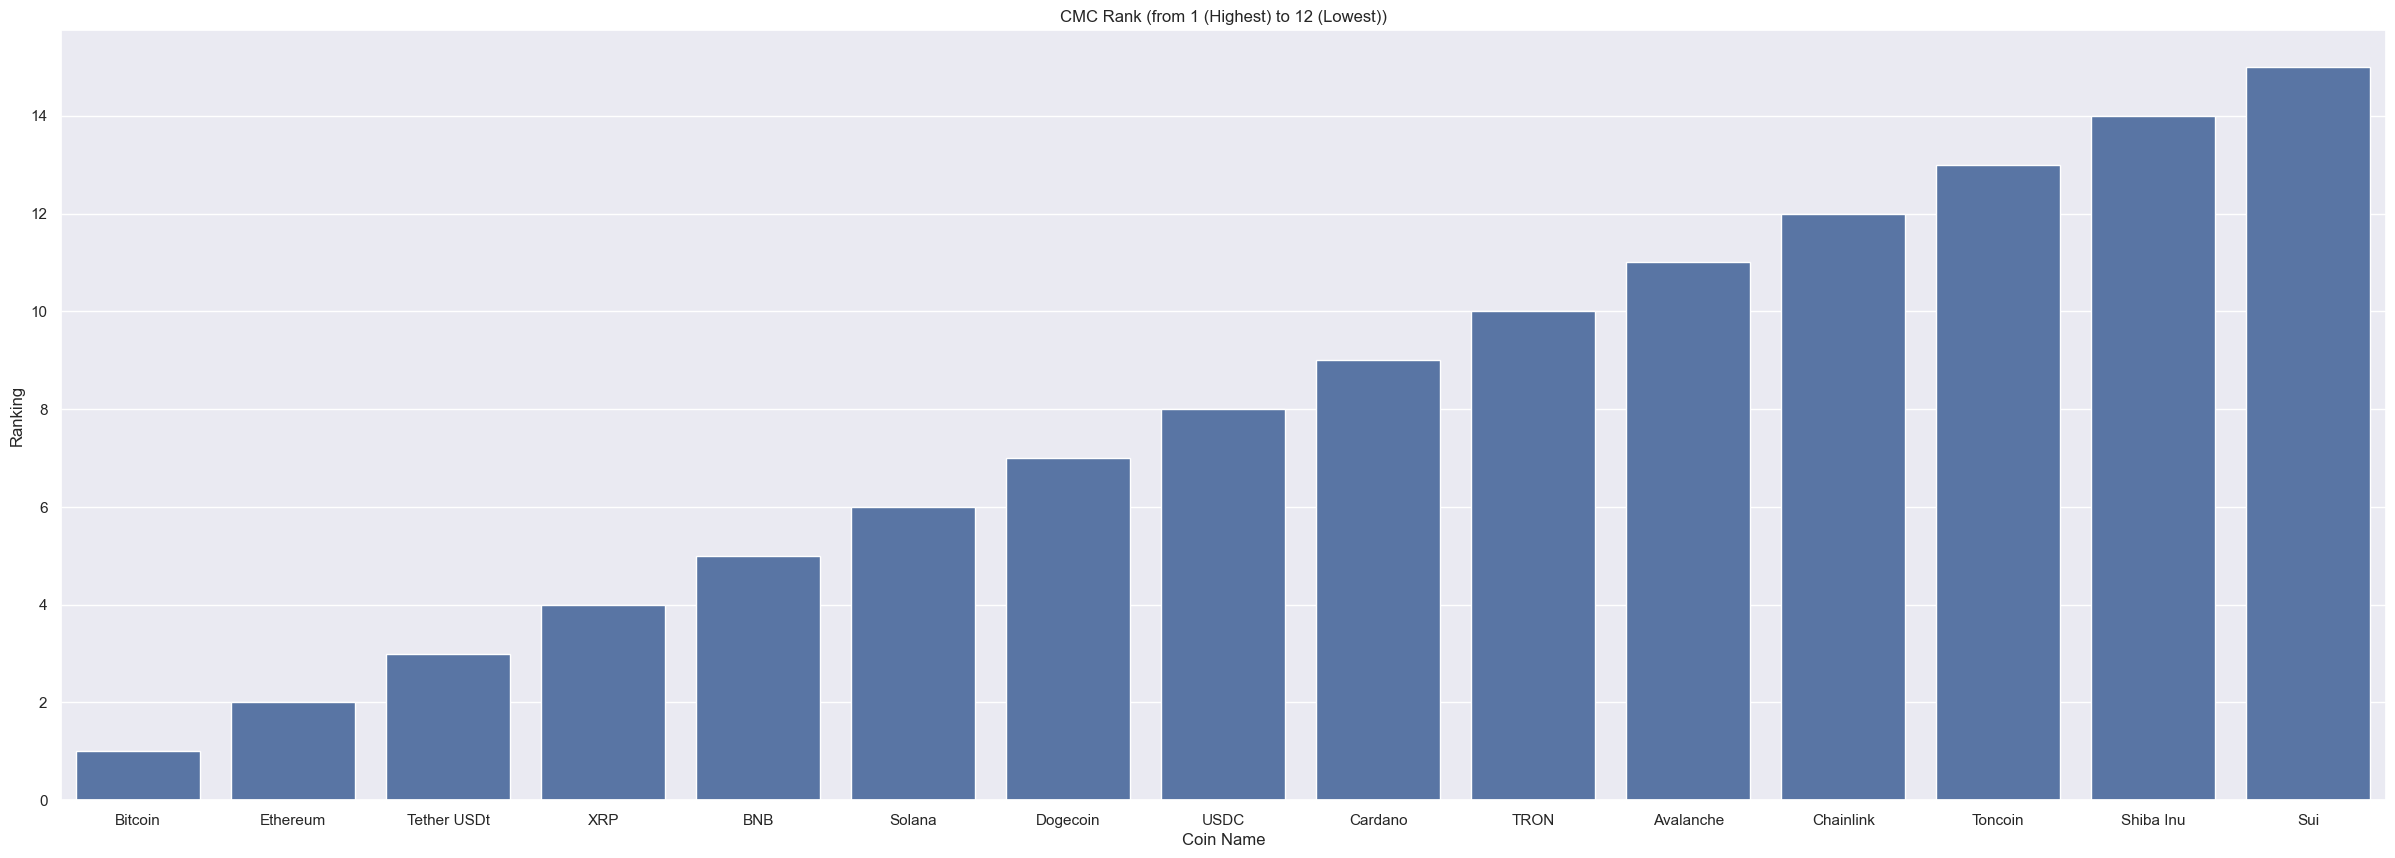

In [26]:
fig, ax = plt.subplots(figsize=(30, 10))
df5 = df.sort_values(by='TimeStamp').groupby('name').agg(CMC_Rank=('cmc_rank', 'last'))
df5 = df5.sort_values(by = 'CMC_Rank',ascending = False)
plot4 = sns.barplot(data=df5,x='name',y='CMC_Rank')
plot4.set_ylabel('Ranking')
plot4.set_xlabel('Coin Name')
plot4.set_title('CMC Rank (from 1 (Highest) to 12 (Lowest))')
plt.gca().invert_xaxis()